# Process pseudomonas data
This notebook does the following:

1. Selects template experiment from the Pseudomonas compendium create from [Tan et. al.](https://msystems.asm.org/content/1/1/e00025-15)
2. Normalizes the gene expression data from the Pseudomonas compendium
3. Train VAE on the normalized data

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import pandas as pd
import numpy as np
from sklearn import preprocessing
import pickle

from ponyo import utils, train_vae_modules
from generic_expression_patterns_modules import process, calc

np.random.seed(123)

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

### Set parameters for data processing

Most parameters are read from `config_filename`. We manually selected bioproject [GEOD-33245](https://www.ebi.ac.uk/arrayexpress/experiments/E-GEOD-33245/?s_sortby=col_8&s_sortorder=ascending), as the template experiment, which contains multiple different comparisons including WT vs *crc* mutants, WT vs *cbr* mutants in different conditions.

In [2]:
base_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))

# Read in config variables
config_filename = os.path.abspath(
    os.path.join(base_dir, "configs", "config_pseudomonas_33245.tsv")
)

params = utils.read_config(config_filename)

local_dir = params["local_dir"]
dataset_name = params["dataset_name"]

# Column header containing sample ids
metadata_colname = params['metadata_colname']

# Template experiment ID
project_id = params['project_id']

# Output file: pickled list of shared genes(generated during gene ID mapping)
shared_genes_filename = params['shared_genes_filename']

# Output files of pseudomonas template experiment data
raw_template_filename = params['raw_template_filename']
#mapped_template_filename = params['mapped_template_filename']
processed_template_filename = params['processed_template_filename']

# Output files of pseudomonas compendium data
raw_compendium_filename = params['raw_compendium_filename']
processed_compendium_filename = params['processed_compendium_filename']
normalized_compendium_filename = params['normalized_compendium_filename']

# Output file: pickled scaler (generated during compendium normalization)
scaler_filename = params['scaler_filename']

# Load metadata file with grouping assignments for samples
sample_id_metadata_filename = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "metadata",
    f"{project_id}_process_samples.tsv")

### Transpose raw pseudomonas compendium and normalize it
The compendium is from https://raw.githubusercontent.com/greenelab/adage/master/Data_collection_processing/Pa_compendium_02.22.2014.pcl

In [3]:
process.process_raw_compendium_pseudomonas(
    raw_compendium_filename,
    processed_compendium_filename,
    normalized_compendium_filename,
    scaler_filename,
)

### Select template experiment and drop subset of samples

We manually selected bioproject selected [GEOD-33245](https://www.ebi.ac.uk/arrayexpress/experiments/E-GEOD-33245/?s_sortby=col_8&s_sortorder=ascending), which contains multiple different comparisons including WT vs *crc* mutants, WT vs *cbr* mutants in different conditions.

In [4]:
process.process_raw_template_pseudomonas(
    processed_compendium_filename,
    project_id,
    dataset_name,
    metadata_colname,
    sample_id_metadata_filename,
    raw_template_filename,
    processed_template_filename,
)

In [5]:
# Check
template_data = pd.read_csv(
    processed_template_filename, 
    header=0,
    index_col=0,
    sep="\t"
)

if project_id == "E-GEOD-33245":
    assert(template_data.shape[0] == 4)

**Note:**
* We are training our VAE model using ALL the data in the compendium.  
* The template experiment is using a subset of the samples in the real experiment and using those in the DE analysis in order to ensure the comparison of samples with consistent backgrounds (i.e. some experiments have samples with 3 different biological conditions and for now our statistical test is doing a binary comparison).
* Simulated experiments are generated by shifting the template experiment (using ALL samples in the real experiment) in the latent space. Then dropping the samples to match the template experiment and perform DE analysis.


So there is an inconsistency in the samples used to learn a low-dimensional representation and those used to calculate DE statistics. This inconsistency should not not change the simulated experiments since all samples in the template experiment are moved the same amount in the latent space. The only way for this inconsistency to effect the simulated experiments is if the low dimensional space is significantly different including all the experiment samples vs only including a subset. However, we believe that such few samples will likely not effect the space. Furthermore, the dataset used to train the VAE should be a general representation of gene expression patterns and shouldn't have to be include the template experiment.

### Train VAE 

In [6]:
# Create VAE directories if needed
output_dirs = [
    os.path.join(base_dir, dataset_name, "models"),
    os.path.join(base_dir, dataset_name, "logs")
]

NN_architecture = params['NN_architecture']

# Check if NN architecture directory exist otherwise create
for each_dir in output_dirs:
    sub_dir = os.path.join(each_dir, NN_architecture)
    os.makedirs(sub_dir, exist_ok=True)

input dataset contains 950 samples and 5549 genes
Instructions for updating:
Colocations handled automatically by placer.
tracking <tf.Variable 'Variable:0' shape=() dtype=float32> beta
Instructions for updating:
Use tf.cast instead.


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output custom_variational_layer_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to custom_variational_layer_1.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 712 samples, validate on 238 samples
Epoch 1/100
712/712 [==============================] - 31s 44ms/step - loss: 3519.7467 - val_loss: 3718.3970
Epoch 2/100
712/712 [==============================] - 30s 42ms/step - loss: 3477.0322 - val_loss: 3538.8910
Epoch 3/100
712/712 [==============================] - 30s 42ms/step - loss: 3465.8347 - val_loss: 3450.7159
Epoch 4/100
712/712 [==============================] - 30s 42ms/step - loss: 3453.2178 - val_loss: 3436.2781
Epoch 5/100
712/712 [==============================] - 30s 42ms/step - loss: 3448.2561 - val_loss: 3430.3111
Epoch 6/100
712/712 [==============================] - 30s 42ms/step - loss: 3436.3102 - val_loss: 3424.3456
Epoch 7/100
712/712 [==============================] - 30s 43ms/step - loss: 3433.0736 - val_loss: 3411.4579
Epoch 8/100
712/712 [==============================] - 30s 42ms/step - loss: 3425.5651 - val_loss: 3414.5145
Epoch 9/100
712/712 [==============================] - 30s 42ms/step - loss: 3418.

712/712 [==============================] - 30s 42ms/step - loss: 3287.0571 - val_loss: 3303.3924
Epoch 76/100
712/712 [==============================] - 30s 42ms/step - loss: 3288.0503 - val_loss: 3300.2322
Epoch 77/100
712/712 [==============================] - 30s 42ms/step - loss: 3287.8880 - val_loss: 3300.7061
Epoch 78/100
712/712 [==============================] - 30s 42ms/step - loss: 3287.5723 - val_loss: 3302.0828
Epoch 79/100
712/712 [==============================] - 30s 42ms/step - loss: 3284.4647 - val_loss: 3300.6306
Epoch 80/100
712/712 [==============================] - 31s 43ms/step - loss: 3285.7712 - val_loss: 3299.9983
Epoch 81/100
712/712 [==============================] - 30s 43ms/step - loss: 3284.2461 - val_loss: 3300.0932
Epoch 82/100
712/712 [==============================] - 30s 42ms/step - loss: 3284.7717 - val_loss: 3302.6292
Epoch 83/100
712/712 [==============================] - 30s 43ms/step - loss: 3284.1242 - val_loss: 3301.5011
Epoch 84/100
712/712 [=

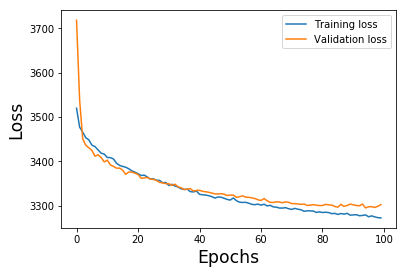

In [7]:
# Train VAE on new compendium data
train_vae_modules.train_vae(config_filename,
                            normalized_compendium_filename)